In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('UNSW_NB15_training-set.csv')

In [4]:
df = df.sample(n=80000, replace=True)

In [5]:
# view dimensions of dataset
df.shape

(80000, 45)

In [6]:
df.attack_cat.value_counts()

Normal            25682
Generic           18241
Exploits          15250
Fuzzers            8256
DoS                5665
Reconnaissance     4682
Analysis            902
Backdoor            744
Shellcode           526
Worms                52
Name: attack_cat, dtype: int64

In [7]:
# find categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :', categorical)
# check for cardinality in categorical variables
for var in categorical:    
    print(var, ' contains ', len(df[var].unique()), ' labels')

There are 4 categorical variables

The categorical variables are : ['proto', 'service', 'state', 'attack_cat']
proto  contains  132  labels
service  contains  13  labels
state  contains  6  labels
attack_cat  contains  10  labels


In [8]:
#new
df['proto'] = df['proto'].astype('category')
df['service'] = df['service'].astype('category')
df['state'] = df['state'].astype('category')
df['attack_cat'] = df['attack_cat'].astype('category')
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [9]:
df[cat_columns].head(10)

,proto,service,state,attack_cat
38603,118,0,0,6
43827,112,0,2,6
67603,112,3,2,4
158346,118,2,3,5
31926,112,0,2,6
77986,112,0,2,4
125570,118,2,3,5
44976,112,5,2,6
9325,112,0,2,6
104316,112,0,2,6


In [10]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()

<Figure size 432x288 with 0 Axes>

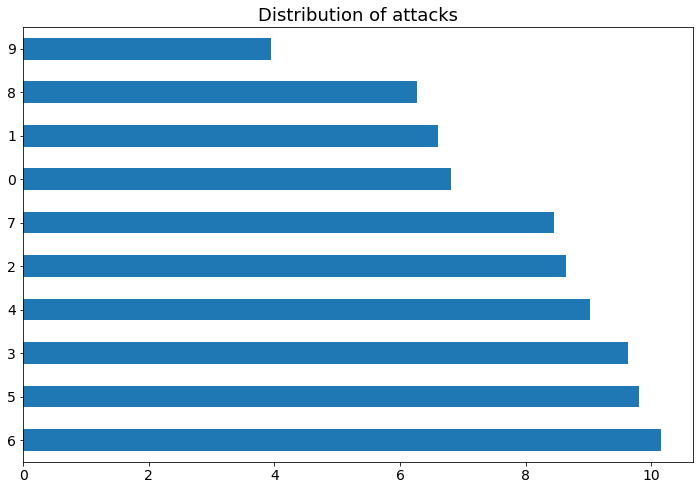

In [11]:
plt.clf()
plt.figure(figsize=(12,8))
params = {'axes.titlesize':'18',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)
plt.title('Distribution of attacks')
#df.plot(kind='barh')
df['attack_cat'].value_counts().apply(np.log).plot(kind='barh')

plt.show()

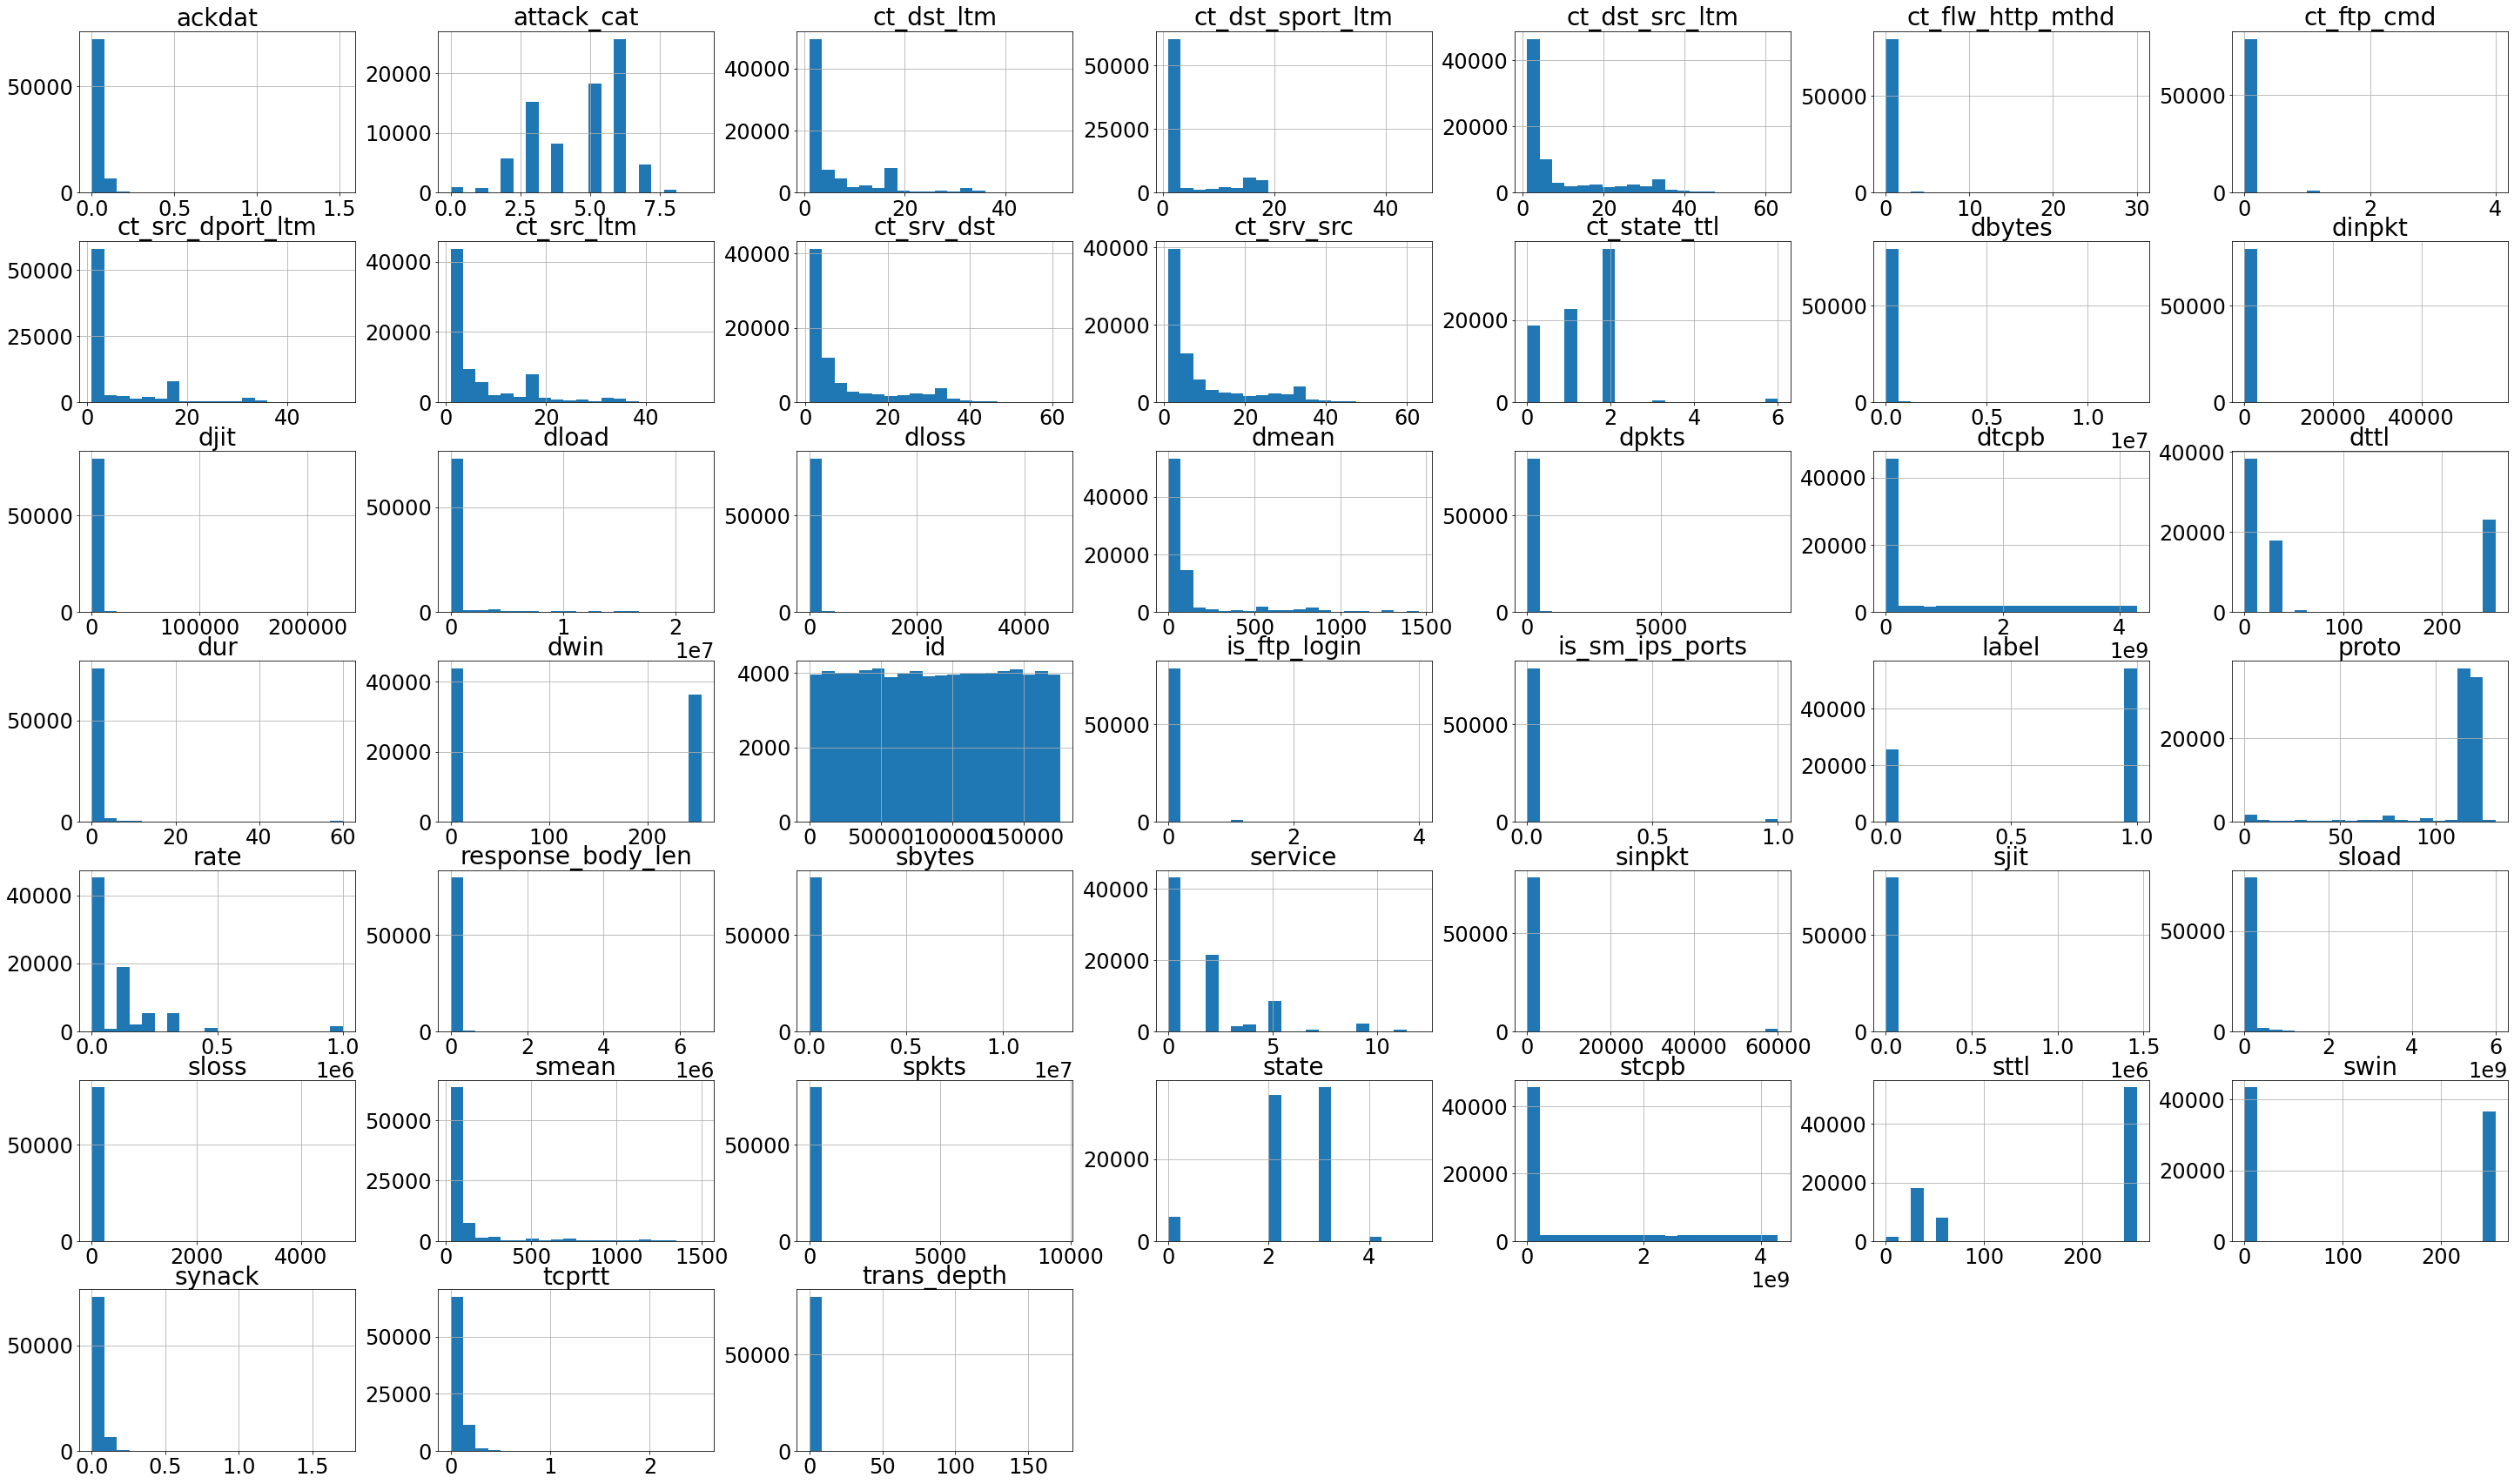

In [12]:
params = {'axes.titlesize':'28',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
matplotlib.rcParams.update(params)
df.hist(figsize=(50, 30), bins=20)
plt.show()

In [13]:
X = df.iloc[:, df.columns!='attack_cat']
Y = df.iloc[:, 43]

In [14]:
names_inputed = ['id',
 'dur',
 'proto',
 'service',
 'state',
 'spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'sloss',
 'dloss',
 'sinpkt',
 'dinpkt',
 'sjit',
 'djit',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'tcprtt',
 'synack',
 'ackdat',
 'smean',
 'dmean',
 'trans_depth',
 'response_body_len',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_flw_http_mthd',
 'ct_src_ltm',
 'ct_srv_dst',
 'is_sm_ips_ports',
 'label']

In [15]:
#StandardScaler
from sklearn.preprocessing import StandardScaler
sScaler = StandardScaler()
rescaleX = sScaler.fit_transform(X)
df_rescaled = pd.DataFrame(data=rescaleX, columns=names_inputed)

In [16]:
#normalization
from sklearn.preprocessing import Normalizer
norm = Normalizer()
xNormalize = norm.fit_transform(X)
df_Normalized = pd.DataFrame(data=xNormalize, columns=names_inputed)

In [41]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(rescaleX, Y, test_size=0.3) # 70% training and 30% test

In [43]:
X_train.shape

(56000, 44)

In [44]:
X_test.shape

(24000, 44)

In [68]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Accuracy: 0.8929166666666667
              precision    recall  f1-score   support

           0       0.46      0.44      0.45       266
           1       0.46      0.45      0.45       229
           2       0.52      0.50      0.51      1628
           3       0.78      0.81      0.80      4593
           4       0.90      0.92      0.91      2502
           5       1.00      0.99      0.99      5489
           6       1.00      1.00      1.00      7591
           7       0.86      0.81      0.83      1535
           8       0.71      0.74      0.72       152
           9       1.00      0.60      0.75        15

    accuracy                           0.89     24000
   macro avg       0.77      0.73      0.74     24000
weighted avg       0.89      0.89      0.89     24000



In [46]:
#testing set confusion matrix
pd.crosstab(y_test, rf_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,118,12,51,71,9,1,0,4,0,0,266
1,10,100,39,54,9,1,0,15,1,0,229
2,35,35,816,577,74,8,0,68,15,0,1628
3,70,51,517,3705,114,13,0,106,17,0,4593
4,17,8,61,84,2309,1,0,12,10,0,2502
5,3,2,13,58,5,5405,0,1,2,0,5489
6,0,0,0,0,0,0,7591,0,0,0,7591
7,7,16,69,166,24,0,0,1253,0,0,1535
8,0,0,2,18,21,0,0,2,109,0,152


In [47]:
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(criterion = 'entropy').fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, dtree_predictions))
print(classification_report(y_test, dtree_predictions))

Accuracy: 0.8829583333333333
              precision    recall  f1-score   support

           0       0.43      0.44      0.43       266
           1       0.46      0.49      0.47       229
           2       0.48      0.51      0.49      1628
           3       0.78      0.76      0.77      4593
           4       0.88      0.90      0.89      2502
           5       0.99      0.99      0.99      5489
           6       1.00      1.00      1.00      7591
           7       0.84      0.81      0.83      1535
           8       0.63      0.70      0.66       152
           9       0.56      0.67      0.61        15

    accuracy                           0.88     24000
   macro avg       0.71      0.73      0.72     24000
weighted avg       0.88      0.88      0.88     24000



In [48]:
#testing set confusion matrix
pd.crosstab(y_test, dtree_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,116,11,59,66,11,1,0,2,0,0,266
1,3,113,37,52,8,2,0,13,1,0,229
2,44,42,823,517,92,18,0,77,13,2,1628
3,85,56,626,3503,134,40,0,123,22,4,4593
4,14,7,75,121,2247,3,0,12,23,0,2502
5,1,2,20,26,7,5430,0,2,1,0,5489
6,0,0,0,0,0,0,7591,0,0,0,7591
7,5,15,69,160,29,1,0,1251,3,2,1535
8,0,2,10,16,13,2,0,2,107,0,152


In [49]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
#fit the model
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
#trainig set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.8207916666666667
              precision    recall  f1-score   support

           0       0.82      0.15      0.25       266
           1       0.00      0.00      0.00       229
           2       0.31      0.02      0.03      1628
           3       0.58      0.89      0.70      4593
           4       0.71      0.75      0.73      2502
           5       0.98      0.98      0.98      5489
           6       1.00      1.00      1.00      7591
           7       0.65      0.47      0.54      1535
           8       0.00      0.00      0.00       152
           9       0.00      0.00      0.00        15

    accuracy                           0.82     24000
   macro avg       0.51      0.43      0.42     24000
weighted avg       0.80      0.82      0.79     24000



In [50]:
#testing set confusion matrix
pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,2,3,4,5,6,7,All
True,,,,,,,,
0,40,2,211,2,7,0,4,266
1,0,2,189,16,4,0,18,229
2,1,28,1426,71,50,0,52,1628
3,3,32,4073,347,38,0,100,4593
4,3,11,443,1886,22,0,137,2502
5,0,7,86,20,5366,0,10,5489
6,0,0,0,0,0,7591,0,7591
7,2,7,550,249,12,0,715,1535
8,0,0,40,55,0,0,57,152


In [51]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)  
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions)) 
print(classification_report(y_test, knn_predictions))

Accuracy: 0.82375
              precision    recall  f1-score   support

           0       0.33      0.19      0.24       266
           1       0.09      0.03      0.05       229
           2       0.33      0.39      0.36      1628
           3       0.66      0.72      0.69      4593
           4       0.76      0.79      0.78      2502
           5       1.00      0.98      0.99      5489
           6       1.00      1.00      1.00      7591
           7       0.67      0.52      0.59      1535
           8       0.41      0.14      0.21       152
           9       0.00      0.00      0.00        15

    accuracy                           0.82     24000
   macro avg       0.52      0.48      0.49     24000
weighted avg       0.82      0.82      0.82     24000



In [52]:
#testing set confusion matrix
pd.crosstab(y_test, knn_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,All
True,,,,,,,,,,
0,50,1,90,114,4,0,0,7,0,266
1,8,7,94,92,15,0,0,13,0,229
2,34,20,638,822,56,5,0,49,4,1628
3,37,32,797,3322,245,11,4,139,6,4593
4,9,4,121,249,1980,4,0,119,16,2502
5,5,1,22,64,14,5377,0,6,0,5489
6,2,0,0,4,10,0,7575,0,0,7591
7,5,13,142,341,230,0,0,800,4,1535
8,1,0,6,16,47,0,0,61,21,152


# with feature selection but class imbalancing

### Info Gain Attribute Eval(CA) feature selection without class balance

In [15]:
#Info Gain Attribute Eval(CA)
features = ['sttl','ct_state_ttl','ct_flw_http_mthd','sbytes','id','smean','sload','dur','sinpkt','rate','proto','ct_dst_src_ltm','service','dbytes','sjit','ct_srv_dst','dload','dinpkt','dmean','ct_srv_src','synack','tcprtt','ct_dst_sport_ltm','djit','ct_src_dport_ltm','dtcpb','stcpb','spkts','dloss','ct_dst_ltm','ackdat','label','dpkts','ct_src_ltm','sloss']
X2 = df[['sttl','ct_state_ttl','ct_flw_http_mthd','sbytes','id','smean','sload','dur','sinpkt','rate','proto','ct_dst_src_ltm','service','dbytes','sjit','ct_srv_dst','dload','dinpkt','dmean','ct_srv_src','synack','tcprtt','ct_dst_sport_ltm','djit','ct_src_dport_ltm','dtcpb','stcpb','spkts','dloss','ct_dst_ltm','ackdat','label','dpkts','ct_src_ltm','sloss']]
Y2 = df[['attack_cat']]
X3 = X2.iloc[:,0:35]  #independent columns
Y3 = Y2.iloc[:,-1]    #target column 

In [16]:
from sklearn.preprocessing import StandardScaler
sScaler = StandardScaler()
rescaleX3 = sScaler.fit_transform(X3)
df_rescaled = pd.DataFrame(data=rescaleX3, columns=features)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(rescaleX3, Y3, test_size=0.3)

In [18]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Accuracy: 0.8927916666666667
              precision    recall  f1-score   support

           0       0.47      0.46      0.46       276
           1       0.41      0.43      0.42       221
           2       0.53      0.47      0.50      1677
           3       0.77      0.83      0.80      4573
           4       0.91      0.92      0.91      2561
           5       0.99      0.98      0.99      5452
           6       1.00      1.00      1.00      7548
           7       0.86      0.83      0.84      1496
           8       0.76      0.71      0.73       180
           9       1.00      0.44      0.61        16

    accuracy                           0.89     24000
   macro avg       0.77      0.71      0.73     24000
weighted avg       0.89      0.89      0.89     24000



In [19]:
dtree_model = DecisionTreeClassifier(criterion = 'entropy').fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, dtree_predictions))
print(classification_report(y_test, dtree_predictions))

Accuracy: 0.8827083333333333
              precision    recall  f1-score   support

           0       0.43      0.45      0.44       276
           1       0.35      0.40      0.37       221
           2       0.50      0.49      0.50      1677
           3       0.78      0.78      0.78      4573
           4       0.89      0.89      0.89      2561
           5       0.99      0.99      0.99      5452
           6       1.00      1.00      1.00      7548
           7       0.83      0.82      0.82      1496
           8       0.68      0.67      0.67       180
           9       0.65      0.69      0.67        16

    accuracy                           0.88     24000
   macro avg       0.71      0.72      0.71     24000
weighted avg       0.88      0.88      0.88     24000



In [20]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
#fit the model
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print('Model accuracy score: {0:0.5f}'. format(accuracy_score(y_test, y_pred_test)))
print(classification_report(y_test, y_pred_test))

Model accuracy score: 0.81821
              precision    recall  f1-score   support

           0       0.74      0.14      0.24       276
           1       0.00      0.00      0.00       221
           2       0.41      0.01      0.01      1677
           3       0.58      0.88      0.70      4573
           4       0.71      0.76      0.73      2561
           5       0.98      0.98      0.98      5452
           6       1.00      1.00      1.00      7548
           7       0.60      0.49      0.54      1496
           8       0.00      0.00      0.00       180
           9       0.00      0.00      0.00        16

    accuracy                           0.82     24000
   macro avg       0.50      0.43      0.42     24000
weighted avg       0.80      0.82      0.79     24000



In [21]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)  
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions)) 
print(classification_report(y_test, knn_predictions))

Accuracy: 0.8249583333333333
              precision    recall  f1-score   support

           0       0.46      0.22      0.30       276
           1       0.11      0.03      0.04       221
           2       0.35      0.36      0.36      1677
           3       0.65      0.74      0.69      4573
           4       0.76      0.79      0.78      2561
           5       1.00      0.98      0.99      5452
           6       1.00      1.00      1.00      7548
           7       0.64      0.53      0.58      1496
           8       0.55      0.17      0.26       180
           9       0.00      0.00      0.00        16

    accuracy                           0.82     24000
   macro avg       0.55      0.48      0.50     24000
weighted avg       0.82      0.82      0.82     24000



### CorrelationAttributeEval feature selection without class balance

In [22]:
#CorrelationAttributeEval
features = ['id','ct_dst_sport_ltm','ct_dst_src_ltm','ct_src_dport_ltm','sttl','ct_srv_dst','ct_srv_src','ct_dst_ltm','ct_src_ltm','ct_state_ttl','state','swin','dwin','proto','service','rate','dttl','stcpb','dtcpb','dmean','dload','tcprtt','ackdat','synack']
X2 = df[['id','ct_dst_sport_ltm','ct_dst_src_ltm','ct_src_dport_ltm','sttl','ct_srv_dst','ct_srv_src','ct_dst_ltm','ct_src_ltm','ct_state_ttl','state','swin','dwin','proto','service','rate','dttl','stcpb','dtcpb','dmean','dload','tcprtt','ackdat','synack']]
Y2 = df[['attack_cat']]
X3 = X2.iloc[:,0:24]  #independent columns
Y3 = Y2.iloc[:,-1]    #target column 

In [23]:
from sklearn.preprocessing import StandardScaler
sScaler = StandardScaler()
rescaleX3 = sScaler.fit_transform(X3)
df_rescaled = pd.DataFrame(data=rescaleX3, columns=features)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(rescaleX3, Y3, test_size=0.3)

In [25]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Accuracy: 0.8631666666666666
              precision    recall  f1-score   support

           0       0.53      0.43      0.48       299
           1       0.40      0.34      0.37       239
           2       0.51      0.45      0.47      1692
           3       0.74      0.81      0.77      4571
           4       0.82      0.87      0.85      2452
           5       0.99      0.98      0.99      5504
           6       0.99      0.98      0.98      7542
           7       0.73      0.73      0.73      1515
           8       0.51      0.25      0.34       169
           9       1.00      0.12      0.21        17

    accuracy                           0.86     24000
   macro avg       0.72      0.60      0.62     24000
weighted avg       0.86      0.86      0.86     24000



In [27]:
dtree_model = DecisionTreeClassifier(criterion = 'entropy').fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, dtree_predictions))
print(classification_report(y_test, dtree_predictions))

Accuracy: 0.8487916666666667
              precision    recall  f1-score   support

           0       0.52      0.45      0.49       299
           1       0.33      0.34      0.34       239
           2       0.47      0.47      0.47      1692
           3       0.75      0.74      0.74      4571
           4       0.82      0.83      0.82      2452
           5       0.98      0.99      0.99      5504
           6       0.98      0.98      0.98      7542
           7       0.67      0.69      0.68      1515
           8       0.41      0.36      0.38       169
           9       0.40      0.24      0.30        17

    accuracy                           0.85     24000
   macro avg       0.63      0.61      0.62     24000
weighted avg       0.85      0.85      0.85     24000



In [28]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
#fit the model
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print('Model accuracy score: {0:0.5f}'. format(accuracy_score(y_test, y_pred_test)))
print(classification_report(y_test, y_pred_test))

Model accuracy score: 0.74529
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       299
           1       0.00      0.00      0.00       239
           2       0.33      0.08      0.13      1692
           3       0.52      0.83      0.64      4571
           4       0.52      0.56      0.54      2452
           5       0.97      0.98      0.98      5504
           6       0.90      0.91      0.91      7542
           7       0.61      0.24      0.34      1515
           8       0.00      0.00      0.00       169
           9       0.00      0.00      0.00        17

    accuracy                           0.75     24000
   macro avg       0.39      0.36      0.35     24000
weighted avg       0.72      0.75      0.72     24000



In [29]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)  
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions)) 
print(classification_report(y_test, knn_predictions))

Accuracy: 0.7688333333333334
              precision    recall  f1-score   support

           0       0.31      0.17      0.22       299
           1       0.12      0.05      0.07       239
           2       0.33      0.35      0.34      1692
           3       0.61      0.71      0.66      4571
           4       0.60      0.62      0.61      2452
           5       1.00      0.98      0.99      5504
           6       0.94      0.93      0.93      7542
           7       0.56      0.41      0.47      1515
           8       0.16      0.04      0.06       169
           9       0.00      0.00      0.00        17

    accuracy                           0.77     24000
   macro avg       0.46      0.43      0.43     24000
weighted avg       0.76      0.77      0.76     24000



### Principal Component Analysis feature selection without class balance

In [30]:
#Principal Component Analysis
features = ['id','dur','dwin','proto','djit','swin','smean','state','service','ct_src_dport_ltm','ct_dst_ltm','ct_dst_sport_ltm','ct_src_ltm','ct_flw_http_mthd','ct_srv_dst','dpkts','dloss','dbytes','sttl','dmean','spkts','sbytes','sloss','sinpkt','label']
X2 = df[['id','dur','dwin','proto','djit','swin','smean','state','service','ct_src_dport_ltm','ct_dst_ltm','ct_dst_sport_ltm','ct_src_ltm','ct_flw_http_mthd','ct_srv_dst','dpkts','dloss','dbytes','sttl','dmean','spkts','sbytes','sloss','sinpkt','label']]
Y2 = df[['attack_cat']]
X3 = X2.iloc[:,0:25]  #independent columns
Y3 = Y2.iloc[:,-1]    #target column 

In [31]:
from sklearn.preprocessing import StandardScaler
sScaler = StandardScaler()
rescaleX3 = sScaler.fit_transform(X3)
df_rescaled = pd.DataFrame(data=rescaleX3, columns=features)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(rescaleX3, Y3, test_size=0.3)

In [33]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Accuracy: 0.8933333333333333
              precision    recall  f1-score   support

           0       0.50      0.48      0.49       276
           1       0.42      0.41      0.41       200
           2       0.54      0.49      0.51      1735
           3       0.78      0.81      0.80      4559
           4       0.90      0.92      0.91      2485
           5       0.99      0.99      0.99      5462
           6       1.00      1.00      1.00      7586
           7       0.85      0.84      0.85      1500
           8       0.75      0.67      0.71       182
           9       1.00      0.47      0.64        15

    accuracy                           0.89     24000
   macro avg       0.77      0.71      0.73     24000
weighted avg       0.89      0.89      0.89     24000



In [34]:
dtree_model = DecisionTreeClassifier(criterion = 'entropy').fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, dtree_predictions))
print(classification_report(y_test, dtree_predictions))

Accuracy: 0.8846666666666667
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       276
           1       0.39      0.42      0.41       200
           2       0.51      0.51      0.51      1735
           3       0.79      0.77      0.78      4559
           4       0.89      0.90      0.89      2485
           5       0.99      0.99      0.99      5462
           6       1.00      1.00      1.00      7586
           7       0.82      0.84      0.83      1500
           8       0.67      0.59      0.63       182
           9       0.56      0.33      0.42        15

    accuracy                           0.88     24000
   macro avg       0.71      0.68      0.69     24000
weighted avg       0.88      0.88      0.88     24000



In [35]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
#fit the model
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))
print(classification_report(y_test, y_pred_test))

Model accuracy score: 0.8045
              precision    recall  f1-score   support

           0       0.90      0.10      0.18       276
           1       0.00      0.00      0.00       200
           2       0.47      0.01      0.03      1735
           3       0.57      0.87      0.69      4559
           4       0.61      0.75      0.67      2485
           5       0.98      0.98      0.98      5462
           6       1.00      1.00      1.00      7586
           7       0.60      0.35      0.45      1500
           8       0.00      0.00      0.00       182
           9       0.00      0.00      0.00        15

    accuracy                           0.80     24000
   macro avg       0.51      0.41      0.40     24000
weighted avg       0.79      0.80      0.77     24000



In [36]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)  
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions)) 
print(classification_report(y_test, knn_predictions))

Accuracy: 0.8400833333333333
              precision    recall  f1-score   support

           0       0.45      0.26      0.33       276
           1       0.13      0.07      0.09       200
           2       0.36      0.36      0.36      1735
           3       0.67      0.75      0.71      4559
           4       0.83      0.82      0.83      2485
           5       1.00      0.98      0.99      5462
           6       1.00      1.00      1.00      7586
           7       0.73      0.69      0.71      1500
           8       0.61      0.20      0.30       182
           9       0.00      0.00      0.00        15

    accuracy                           0.84     24000
   macro avg       0.58      0.51      0.53     24000
weighted avg       0.84      0.84      0.84     24000



# After Class Balancing with feature selection

In [17]:
from sklearn.utils import resample
df_minority0 = df[df.attack_cat==0]
df_minority1 = df[df.attack_cat==1]
df_minority2 = df[df.attack_cat==2]
df_minority3 = df[df.attack_cat==3]
df_minority7 = df[df.attack_cat==7]
df_minority8 = df[df.attack_cat==8]
df_minority9 = df[df.attack_cat==9]

In [18]:
df_minority_upsampled0 = resample(df_minority0, 
                                 replace=True,     # sample with replacement
                                 n_samples=5000)    # to match majority class
df_minority_upsampled1 = resample(df_minority1, 
                                 replace=True,     # sample with replacement
                                 n_samples=5000)    # to match majority class
df_minority_upsampled2 = resample(df_minority2, 
                                 replace=True,     # sample with replacement
                                 n_samples=6000)    # to match majority class
df_minority_upsampled3 = resample(df_minority3, 
                                 replace=True,     # sample with replacement
                                 n_samples=6000)    # to match majority class
df_minority_upsampled7 = resample(df_minority7, 
                                 replace=True,     # sample with replacement
                                 n_samples=3000)    # to match majority class
df_minority_upsampled8 = resample(df_minority8, 
                                 replace=True,     # sample with replacement
                                 n_samples=5000)
df_minority_upsampled9 = resample(df_minority9, 
                                 replace=True,     # sample with replacement
                                 n_samples=6000)    # to match majority class
df = pd.concat([df, df_minority_upsampled0, df_minority_upsampled1, df_minority_upsampled2, df_minority_upsampled3, df_minority_upsampled7, df_minority_upsampled8, df_minority_upsampled9])

In [19]:
df.attack_cat.value_counts()

6    25682
3    21250
5    18241
2    11665
4     8256
7     7682
9     6052
0     5902
1     5744
8     5526
Name: attack_cat, dtype: int64

In [20]:
df.shape

(116000, 45)

In [72]:
#Info Gain Attribute Eval(CA)
features = ['sttl','ct_state_ttl','ct_flw_http_mthd','sbytes','id','smean','sload','dur','sinpkt','rate','proto','ct_dst_src_ltm','service','dbytes','sjit','ct_srv_dst','dload','dinpkt','dmean','ct_srv_src','synack','tcprtt','ct_dst_sport_ltm','djit','ct_src_dport_ltm','dtcpb','stcpb','spkts','dloss','ct_dst_ltm','ackdat','label','dpkts','ct_src_ltm','sloss']
X2 = df[['sttl','ct_state_ttl','ct_flw_http_mthd','sbytes','id','smean','sload','dur','sinpkt','rate','proto','ct_dst_src_ltm','service','dbytes','sjit','ct_srv_dst','dload','dinpkt','dmean','ct_srv_src','synack','tcprtt','ct_dst_sport_ltm','djit','ct_src_dport_ltm','dtcpb','stcpb','spkts','dloss','ct_dst_ltm','ackdat','label','dpkts','ct_src_ltm','sloss']]
Y2 = df[['attack_cat']]
X3 = X2.iloc[:,0:35]  #independent columns
Y3 = Y2.iloc[:,-1]    #target column 

In [73]:
from sklearn.preprocessing import StandardScaler
sScaler = StandardScaler()
rescaleX3 = sScaler.fit_transform(X3)
df_rescaled = pd.DataFrame(data=rescaleX3, columns=features)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(rescaleX3, Y3, test_size=0.3)

In [75]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Accuracy: 0.9529022988505748
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1811
           1       0.96      1.00      0.98      1771
           2       0.86      0.87      0.86      3507
           3       0.91      0.89      0.90      6373
           4       0.95      0.92      0.94      2406
           5       1.00      0.98      0.99      5500
           6       1.00      1.00      1.00      7582
           7       0.93      0.91      0.92      2323
           8       0.98      1.00      0.99      1689
           9       1.00      1.00      1.00      1838

    accuracy                           0.95     34800
   macro avg       0.95      0.96      0.95     34800
weighted avg       0.95      0.95      0.95     34800



In [76]:
#testing set confusion matrix
pd.crosstab(y_test, rf_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1806,0,0,0,0,0,0,5,0,0,1811
1,0,1771,0,0,0,0,0,0,0,0,1771
2,35,27,3063,313,23,7,0,34,5,0,3507
3,75,27,411,5666,71,10,0,93,11,9,6373
4,19,6,43,77,2224,4,0,17,16,0,2406
5,1,2,9,60,9,5415,0,4,0,0,5500
6,0,0,0,0,0,0,7582,0,0,0,7582
7,7,16,52,128,4,6,0,2107,3,0,2323
8,0,0,0,0,0,0,0,0,1689,0,1689


In [77]:
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(criterion = 'entropy').fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, dtree_predictions))
print(classification_report(y_test, dtree_predictions))

Accuracy: 0.9480747126436782
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1811
           1       0.95      1.00      0.97      1771
           2       0.83      0.88      0.85      3507
           3       0.91      0.87      0.89      6373
           4       0.94      0.90      0.92      2406
           5       0.99      0.99      0.99      5500
           6       1.00      1.00      1.00      7582
           7       0.93      0.90      0.92      2323
           8       0.98      1.00      0.99      1689
           9       1.00      1.00      1.00      1838

    accuracy                           0.95     34800
   macro avg       0.95      0.95      0.95     34800
weighted avg       0.95      0.95      0.95     34800



In [78]:
#testing set confusion matrix
pd.crosstab(y_test, dtree_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1806,0,0,5,0,0,0,0,0,0,1811
1,0,1771,0,0,0,0,0,0,0,0,1771
2,44,31,3074,285,25,16,0,26,6,0,3507
3,74,42,514,5513,91,20,0,101,11,7,6373
4,15,8,69,98,2177,6,0,19,13,1,2406
5,3,1,13,31,8,5442,0,2,0,0,5500
6,0,0,0,0,0,0,7582,0,0,0,7582
7,6,15,51,137,8,4,0,2101,1,0,2323
8,0,0,0,0,0,0,0,0,1689,0,1689


In [79]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear', random_state=0)
#fit the model
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.6908045977011494
              precision    recall  f1-score   support

           0       0.76      0.12      0.21      1811
           1       0.19      0.00      0.00      1771
           2       0.33      0.57      0.42      3507
           3       0.56      0.55      0.55      6373
           4       0.68      0.68      0.68      2406
           5       0.98      0.97      0.97      5500
           6       1.00      1.00      1.00      7582
           7       0.49      0.31      0.38      2323
           8       0.54      0.77      0.63      1689
           9       0.60      0.95      0.73      1838

    accuracy                           0.69     34800
   macro avg       0.61      0.59      0.56     34800
weighted avg       0.69      0.69      0.67     34800



In [80]:
#testing set confusion matrix
pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,218,1,832,688,0,28,0,5,28,11,1811
1,4,3,961,486,41,8,0,110,107,51,1771
2,18,2,1991,1104,80,33,0,80,113,86,3507
3,36,8,1562,3491,324,43,0,106,169,634,6373
4,3,2,217,205,1629,13,0,263,36,38,2406
5,1,0,32,57,13,5358,0,20,6,13,5500
6,0,0,0,0,0,0,7582,0,0,0,7582
7,5,0,357,132,155,10,0,727,617,320,2323
8,0,0,38,23,153,0,0,171,1304,0,1689


In [81]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)  
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions)) 
print(classification_report(y_test, knn_predictions))

Accuracy: 0.8301436781609195
              precision    recall  f1-score   support

           0       0.66      0.89      0.76      1811
           1       0.69      0.94      0.80      1771
           2       0.54      0.52      0.53      3507
           3       0.73      0.66      0.69      6373
           4       0.80      0.72      0.75      2406
           5       1.00      0.98      0.99      5500
           6       1.00      1.00      1.00      7582
           7       0.75      0.61      0.68      2323
           8       0.85      0.99      0.92      1689
           9       0.97      1.00      0.99      1838

    accuracy                           0.83     34800
   macro avg       0.80      0.83      0.81     34800
weighted avg       0.83      0.83      0.83     34800



In [83]:
#testing set confusion matrix
pd.crosstab(y_test, knn_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1612,31,79,84,0,0,0,5,0,0,1811
1,28,1659,41,27,2,0,0,11,3,0,1771
2,330,275,1840,886,62,10,0,81,21,2,3507
3,361,265,1041,4179,222,6,8,206,49,36,6373
4,55,53,151,169,1721,0,3,150,101,3,2406
5,7,11,31,53,15,5378,0,2,2,1,5500
6,0,1,0,3,11,0,7566,0,1,0,7582
7,48,107,192,302,123,2,0,1422,116,11,2323
8,0,0,6,0,0,0,0,9,1674,0,1689


In [84]:
#CorrelationAttributeEval
features = ['id','ct_dst_sport_ltm','ct_dst_src_ltm','ct_src_dport_ltm','sttl','ct_srv_dst','ct_srv_src','ct_dst_ltm','ct_src_ltm','ct_state_ttl','state','swin','dwin','proto','service','rate','dttl','stcpb','dtcpb','dmean','dload','tcprtt','ackdat','synack']
X2 = df[['id','ct_dst_sport_ltm','ct_dst_src_ltm','ct_src_dport_ltm','sttl','ct_srv_dst','ct_srv_src','ct_dst_ltm','ct_src_ltm','ct_state_ttl','state','swin','dwin','proto','service','rate','dttl','stcpb','dtcpb','dmean','dload','tcprtt','ackdat','synack']]
Y2 = df[['attack_cat']]
X3 = X2.iloc[:,0:24]  #independent columns
Y3 = Y2.iloc[:,-1]    #target column 

In [85]:
from sklearn.preprocessing import StandardScaler
sScaler = StandardScaler()
rescaleX3 = sScaler.fit_transform(X3)
df_rescaled = pd.DataFrame(data=rescaleX3, columns=features)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(rescaleX3, Y3, test_size=0.3)

In [87]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Accuracy: 0.9357183908045977
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1812
           1       0.94      1.00      0.97      1707
           2       0.85      0.84      0.85      3524
           3       0.89      0.88      0.89      6331
           4       0.87      0.86      0.87      2539
           5       1.00      0.98      0.99      5480
           6       0.99      0.97      0.98      7626
           7       0.88      0.87      0.88      2358
           8       0.97      1.00      0.99      1625
           9       1.00      1.00      1.00      1798

    accuracy                           0.94     34800
   macro avg       0.93      0.94      0.94     34800
weighted avg       0.94      0.94      0.94     34800



In [88]:
#testing set confusion matrix
pd.crosstab(y_test, rf_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1801,0,0,7,4,0,0,0,0,0,1812
1,0,1707,0,0,0,0,0,0,0,0,1707
2,41,38,2976,381,27,4,0,55,2,0,3524
3,79,45,406,5596,69,9,2,113,8,4,6331
4,22,9,56,106,2188,0,65,85,8,0,2539
5,2,2,11,57,4,5397,0,6,1,0,5480
6,7,0,1,12,172,0,7423,11,0,0,7626
7,9,16,52,150,44,5,3,2052,27,0,2358
8,0,0,0,0,0,0,0,0,1625,0,1625


In [89]:
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(criterion = 'entropy').fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, dtree_predictions))
print(classification_report(y_test, dtree_predictions))

Accuracy: 0.9281896551724138
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1812
           1       0.92      1.00      0.96      1707
           2       0.82      0.85      0.83      3524
           3       0.89      0.84      0.87      6331
           4       0.87      0.83      0.85      2539
           5       0.99      0.99      0.99      5480
           6       0.98      0.98      0.98      7626
           7       0.85      0.86      0.85      2358
           8       0.96      1.00      0.98      1625
           9       0.99      1.00      1.00      1798

    accuracy                           0.93     34800
   macro avg       0.92      0.93      0.93     34800
weighted avg       0.93      0.93      0.93     34800



In [90]:
#testing set confusion matrix
pd.crosstab(y_test, dtree_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1801,0,0,7,4,0,0,0,0,0,1812
1,0,1707,0,0,0,0,0,0,0,0,1707
2,43,45,2993,334,32,5,2,68,2,0,3524
3,74,63,505,5342,104,23,14,168,22,16,6331
4,19,12,63,130,2099,7,100,96,13,0,2539
5,1,4,20,33,5,5409,0,7,1,0,5480
6,3,2,4,16,82,0,7503,16,0,0,7626
7,8,19,62,112,83,2,14,2024,33,1,2358
8,0,0,0,0,0,0,0,0,1625,0,1625


In [91]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear', random_state=0)
#fit the model
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.6215804597701149
              precision    recall  f1-score   support

           0       0.41      0.01      0.01      1812
           1       0.15      0.02      0.04      1707
           2       0.31      0.64      0.42      3524
           3       0.53      0.49      0.51      6331
           4       0.49      0.48      0.48      2539
           5       0.97      0.98      0.97      5480
           6       0.89      0.90      0.90      7626
           7       0.35      0.03      0.05      2358
           8       0.41      0.76      0.54      1625
           9       0.56      0.81      0.67      1798

    accuracy                           0.62     34800
   macro avg       0.51      0.51      0.46     34800
weighted avg       0.61      0.62      0.59     34800



In [92]:
#testing set confusion matrix
pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,11,24,967,719,0,21,42,0,20,8,1812
1,8,34,1193,214,80,1,36,9,87,45,1707
2,0,67,2255,770,72,44,74,13,123,106,3524
3,1,75,1838,3129,259,19,159,27,243,581,6331
4,4,8,380,243,1225,40,426,24,108,81,2539
5,0,0,44,55,5,5352,0,1,11,12,5480
6,2,0,65,254,365,15,6863,1,31,30,7626
7,1,15,391,196,302,8,32,63,1083,267,2358
8,0,0,57,17,215,0,54,44,1238,0,1625


In [93]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)  
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions)) 
print(classification_report(y_test, knn_predictions))

Accuracy: 0.7841954022988505
              precision    recall  f1-score   support

           0       0.63      0.86      0.73      1812
           1       0.66      0.94      0.78      1707
           2       0.53      0.53      0.53      3524
           3       0.71      0.65      0.67      6331
           4       0.65      0.52      0.57      2539
           5       1.00      0.98      0.99      5480
           6       0.95      0.92      0.93      7626
           7       0.61      0.46      0.53      2358
           8       0.76      0.99      0.86      1625
           9       0.96      1.00      0.98      1798

    accuracy                           0.78     34800
   macro avg       0.74      0.78      0.76     34800
weighted avg       0.79      0.78      0.78     34800



In [94]:
#testing set confusion matrix
pd.crosstab(y_test, knn_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1564,29,141,72,0,0,0,6,0,0,1812
1,6,1597,61,22,0,0,0,18,3,0,1707
2,353,272,1871,848,41,4,6,95,29,5,3524
3,369,294,973,4086,138,7,42,305,68,49,6331
4,60,80,188,262,1309,7,306,195,130,2,2539
5,6,11,27,57,6,5356,0,14,2,1,5480
6,69,22,37,83,335,0,7021,32,24,3,7626
7,49,103,248,365,193,4,39,1083,262,12,2358
8,0,0,0,0,3,0,0,17,1605,0,1625


In [95]:
#Principal Component Analysis
features = ['id','dur','dwin','proto','djit','swin','smean','state','service','ct_src_dport_ltm','ct_dst_ltm','ct_dst_sport_ltm','ct_src_ltm','ct_flw_http_mthd','ct_srv_dst','dpkts','dloss','dbytes','sttl','dmean','spkts','sbytes','sloss','sinpkt','label']
X2 = df[['id','dur','dwin','proto','djit','swin','smean','state','service','ct_src_dport_ltm','ct_dst_ltm','ct_dst_sport_ltm','ct_src_ltm','ct_flw_http_mthd','ct_srv_dst','dpkts','dloss','dbytes','sttl','dmean','spkts','sbytes','sloss','sinpkt','label']]
Y2 = df[['attack_cat']]
X3 = X2.iloc[:,0:25]  #independent columns
Y3 = Y2.iloc[:,-1]    #target column 

In [96]:
from sklearn.preprocessing import StandardScaler
sScaler = StandardScaler()
rescaleX3 = sScaler.fit_transform(X3)
df_rescaled = pd.DataFrame(data=rescaleX3, columns=features)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(rescaleX3, Y3, test_size=0.3)

In [98]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Accuracy: 0.9508045977011494
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1763
           1       0.95      1.00      0.97      1762
           2       0.84      0.86      0.85      3536
           3       0.91      0.88      0.90      6367
           4       0.94      0.93      0.93      2530
           5       1.00      0.99      0.99      5540
           6       1.00      1.00      1.00      7453
           7       0.92      0.91      0.92      2352
           8       0.98      1.00      0.99      1651
           9       1.00      1.00      1.00      1846

    accuracy                           0.95     34800
   macro avg       0.95      0.96      0.95     34800
weighted avg       0.95      0.95      0.95     34800



In [99]:
#testing set confusion matrix
pd.crosstab(y_test, rf_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1759,0,2,2,0,0,0,0,0,0,1763
1,0,1762,0,0,0,0,0,0,0,0,1762
2,39,33,3038,322,60,6,0,36,2,0,3536
3,51,33,424,5626,78,8,0,130,14,3,6367
4,10,13,56,78,2341,0,0,11,21,0,2530
5,1,3,22,44,9,5461,0,0,0,0,5540
6,0,0,0,0,0,0,7453,0,0,0,7453
7,6,18,64,102,9,2,0,2151,0,0,2352
8,0,0,0,0,0,0,0,0,1651,0,1651


In [100]:
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(criterion = 'entropy').fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
#testing set accuracy
print("Accuracy:",metrics.accuracy_score(y_test, dtree_predictions))
print(classification_report(y_test, dtree_predictions))

Accuracy: 0.9462931034482759
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1763
           1       0.94      1.00      0.97      1762
           2       0.83      0.86      0.85      3536
           3       0.91      0.87      0.89      6367
           4       0.94      0.90      0.92      2530
           5       0.99      0.99      0.99      5540
           6       1.00      1.00      1.00      7453
           7       0.91      0.91      0.91      2352
           8       0.97      1.00      0.99      1651
           9       1.00      1.00      1.00      1846

    accuracy                           0.95     34800
   macro avg       0.94      0.95      0.95     34800
weighted avg       0.95      0.95      0.95     34800



In [101]:
#testing set confusion matrix
pd.crosstab(y_test, dtree_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1761,0,0,2,0,0,0,0,0,0,1763
1,0,1762,0,0,0,0,0,0,0,0,1762
2,37,40,3050,306,51,10,0,38,2,2,3536
3,74,39,476,5521,82,14,0,150,9,2,6367
4,18,14,59,121,2268,6,0,13,31,0,2530
5,2,2,28,29,7,5469,0,2,0,1,5540
6,0,0,0,0,0,0,7453,0,0,0,7453
7,9,17,66,94,10,4,0,2150,2,0,2352
8,0,0,0,0,0,0,0,0,1651,0,1651


In [102]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear', random_state=0)
#fit the model
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.6771551724137931
              precision    recall  f1-score   support

           0       0.73      0.13      0.22      1763
           1       0.22      0.00      0.00      1762
           2       0.33      0.60      0.42      3536
           3       0.58      0.49      0.53      6367
           4       0.66      0.65      0.66      2530
           5       0.98      0.98      0.98      5540
           6       1.00      1.00      1.00      7453
           7       0.44      0.30      0.36      2352
           8       0.48      0.71      0.57      1651
           9       0.56      0.92      0.70      1846

    accuracy                           0.68     34800
   macro avg       0.60      0.58      0.54     34800
weighted avg       0.69      0.68      0.66     34800



In [103]:
#testing set confusion matrix
pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,230,0,909,524,0,21,0,10,61,8,1763
1,3,2,1031,405,53,7,0,112,110,39,1762
2,33,0,2114,909,99,50,0,85,149,97,3536
3,40,6,1737,3129,382,34,0,79,221,739,6367
4,3,0,199,208,1655,17,0,332,53,63,2530
5,2,0,36,44,15,5406,0,18,7,12,5540
6,0,0,0,0,0,0,7453,0,0,0,7453
7,2,1,391,87,105,3,0,714,684,365,2352
8,0,0,40,24,138,0,0,277,1172,0,1651


In [104]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)  
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions)) 
print(classification_report(y_test, knn_predictions))

Accuracy: 0.845948275862069
              precision    recall  f1-score   support

           0       0.66      0.89      0.76      1763
           1       0.70      0.94      0.80      1762
           2       0.58      0.55      0.56      3536
           3       0.75      0.68      0.71      6367
           4       0.89      0.77      0.82      2530
           5       1.00      0.98      0.99      5540
           6       1.00      1.00      1.00      7453
           7       0.80      0.70      0.75      2352
           8       0.87      0.99      0.92      1651
           9       0.97      1.00      0.99      1846

    accuracy                           0.85     34800
   macro avg       0.82      0.85      0.83     34800
weighted avg       0.85      0.85      0.84     34800



In [106]:
#testing set confusion matrix
pd.crosstab(y_test, knn_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1576,31,75,79,2,0,0,0,0,0,1763
1,17,1649,53,23,0,0,0,11,9,0,1762
2,335,268,1943,842,50,3,0,66,29,0,3536
3,381,257,957,4313,136,4,7,215,53,44,6367
4,35,39,101,179,1951,2,0,122,96,5,2530
5,4,6,37,51,14,5425,0,0,3,0,5540
6,1,0,1,0,3,0,7448,0,0,0,7453
7,51,101,183,247,45,2,0,1653,64,6,2352
8,0,0,0,8,0,0,0,8,1635,0,1651
